# We explore this notebook and see how we can make modification to complete our tasks

Some ideas


*   Age, Race, Gender Identification
*   Deployment to mobile devices

Dataset provided in assignment brief: https://susanqq.github.io/UTKFace/



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1) **Import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import cv2
from tensorflow.keras.layers import *
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, r2_score

## 2) **Processing the data**

Create dataset_dict object to id/encode race and gender. We can use this to convert prediction label to text during evaluation.

In [2]:
# definitions for UTKDataset
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())

Import UTKDataset and organize data into pandas dataframe.

In [3]:
dir = './UTKDataset/UTKFace'
# dir = './UTKDataset/UTKInTheWild'

# Fraction of the dataset to be used for testing.
split = 0.3

image_data = []

def parse_data(filename):
  try:
    parts = filename.split('_')
    age = parts[0]
    gender = parts[1]
    race = parts[2]
    return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)], filename
  except Exception as e:
    return None, None, None, None

for i in os.listdir(dir):
  age, gender, race, filename = parse_data(i)
  if age is not None and gender is not None and race is not None and filename is not None:
    image_data.append(parse_data(i))

data = pd.DataFrame(image_data, columns=["age", "gender", "race", "filename"])
data = data.sample(frac=1).reset_index(drop=True) # shuffle dataframe in place and reset index
data.head(10)

,age,gender,race,filename
0,30,female,white,30_1_0_20170117145258777.jpg.chip.jpg
1,3,female,asian,3_1_2_20161219151926867.jpg.chip.jpg
2,30,female,white,30_1_0_20170117135257534.jpg.chip.jpg
3,30,female,white,30_1_0_20170117144452546.jpg.chip.jpg
4,31,male,indian,31_0_3_20170104220255896.jpg.chip.jpg
5,38,male,black,38_0_1_20170113195941277.jpg.chip.jpg
6,58,male,white,58_0_0_20170120222805833.jpg.chip.jpg
7,60,female,white,60_1_0_20170110135905294.jpg.chip.jpg
8,22,female,indian,22_1_3_20170119163326293.jpg.chip.jpg
9,27,male,indian,27_0_3_20170119194352188.jpg.chip.jpg


Sanity check. Plot data distribution for each individual label.

In [4]:
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [ ]:
plot_distribution(data['gender'])
plot_distribution(data['race'])

In [ ]:
fig = px.histogram(data, x="age", nbins=20)
fig.update_layout(title_text='Age distribution on Train Dataset')
fig.show()

In [ ]:
plot_distribution(data['gender'])
plot_distribution(data['race'])

In [ ]:
fig = px.histogram(data, x="age", nbins=20)
fig.update_layout(title_text='Age distribution on Test Dataset')
fig.show()

In [5]:
# Observing viola-jones + histogram equalization
def viola_jones(img_path):
    face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades,'haarcascade_frontalface_default.xml'))

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    images = []
    if len(faces) == 0:
        # return original face if no faces detected
        extracted_image = cv2.equalizeHist(gray)
        return [extracted_image]
    for (x,y,w,h) in faces:
        extracted_image = img[y:y+h, x:x+w]
        extracted_image = cv2.equalizeHist(extracted_image)
        images.append(extracted_image)
    return images
imgs=[]
imgs = viola_jones('./img/test.jpg')
for i in imgs:
    cv2.imwrite('./img/result.jpg', i)

Face dataset generator. Generator class to perform preprocessing on dataset before trainig.

def preprocess_image:
- Perform image augmentation as necessary

def alias:
- Associate labels with their numerical representation if necessary
- Get split index for train, validation and test

def generate_images:
- Load image from filename and labels to be used as training inputs and labels

In [5]:
img_height = 128
img_width = 128
split = 0.7 # train test split

class FaceDataGenerator():
  def __init__(self, dataframe):
    self.dataframe = dataframe    

  def viola_jones(self, img):
    # face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades,'haarcascade_frontalface_default.xml'))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    extracted_image = cv2.equalizeHist(gray)

    # if len(faces) == 0:
    #     return None

    # for (x,y,w,h) in faces:
        # extracted_image = cv2.cvtColor(gray[y:y+h, x:x+w], cv2.COLOR_GRAY2BGR)
        # extracted_image = cv2.equalizeHist(extracted_image)
    return extracted_image

  def preprocess_image(self, file, is_training):
    imgs = cv2.imread(file)

    # if is_training == False:
    imgs = self.viola_jones(imgs)
    if imgs is not None:
      imgs = Image.fromarray(imgs)
      imgs = imgs.resize((img_width, img_height))
      imgs = np.array(imgs) / 255.0
    return imgs
  
  def alias(self):
    p = np.random.permutation(len(self.dataframe))
    train_up_to = int(len(self.dataframe) * split)
    train_idx = p[:train_up_to]
    test_idx = p[train_up_to:]
    train_up_to = int(train_up_to * split)
    train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
    self.dataframe['gender_id'] = self.dataframe['gender'].map(lambda gender: dataset_dict['gender_alias'][gender.strip()])
    self.dataframe['race_id'] = self.dataframe['race'].map(lambda race: dataset_dict['race_alias'][race])
    self.max_age = self.dataframe['age'].max()

    return train_idx, valid_idx, test_idx

  def generate_images(self, i_idx, is_training, batch_size=8):
    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []
    while True:
      for idx in i_idx:
          person = self.dataframe.iloc[idx]
          
          age = person['age']
          race = person['race_id']
          gender = person['gender_id']
          filename = person['filename']
          
          im = self.preprocess_image(dir + '/' + filename, is_training)

          # if im is not None:
          images.append(im)
          
          ages.append(age / self.max_age)
          races.append(to_categorical(race, len(dataset_dict['race_id'])))
          genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
          
          # yielding condition
          if len(images) >= batch_size:
              yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
              images, ages, races, genders = [], [], [], []
          # else:
          #   self.dataframe.drop(idx)
              
      if not is_training:
          break

generator = FaceDataGenerator(data)
train_idx, valid_idx, test_idx = generator.alias()
print(f'Training sample: {len(train_idx)}')
print(f'Validation sample: {len(valid_idx)}')
print(f'Testing sample: {len(test_idx)}')

Training sample: 11615
Validation sample: 4978
Testing sample: 7112



## 3) Model

Our aim is to develop a model which has lesser parameters ( which implies lesser inference time and size ) but powerful enough so that it can generalize better.

* The model takes in a batch of shape `[ None , 128 , 128 , 3 ]` and performs a number of convolutions on it as determined by `num_blocks`.

* We stack such`num_blocks` blocks sequentially, where the no. of filters for each layer is taken from `num_filters`.

* Next we add a number of `Dense` layers to learn the features extracted by convolutional layers.


> See [this](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/) blog for choosing the weight decay values used in the above two blocks.



### Model: Normal Conv2D layer

In [6]:
MODEL_INPUT_IMAGE_SIZE = [128, 128]
# Negative slope coefficient for LeakyReLU.
leaky_relu_alpha = 0.2

# Init a Input Layer.
inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [1])

#################### Combined Classifier #########################
x = inputs

x = Conv2D(16, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

x = Conv2D(32, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(128)(x)
x = Activation("relu")(x)
# x = BatchNormalization()(x)
x = Dropout(0.5)(x)
gender = Dense(2, activation='sigmoid', name='gender_output')(x)
race = tf.keras.layers.Dense(5, activation='softmax', name='race_output')(x)
age = tf.keras.layers.Dense(1, activation='linear', name='age_output')(x)
#################### End of Combined Classifier ##################

# Build the Model
model = tf.keras.models.Model(inputs , [age, race, gender])

# Uncomment the below to view the summary of the model.
model.summary()
# tf.keras.utils.plot_model(model) # add to_file='architecture.png' to export architecture 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          activation[0][0]                 
______________________________________________________________________________________________


Run this cell to visualize the training of the model in TensorBoard ( in this notebook itself ).

### Model: Seperable Convolution layers

In [7]:
MODEL_INPUT_IMAGE_SIZE = [128, 128]
# Negative slope coefficient for LeakyReLU.
leaky_relu_alpha = 0.2

# Init a Input Layer.
inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [3])

#################### Combined Classifier #########################
x = inputs

# x = Conv2D(16, (3, 3), padding="same")(x)
x = SeparableConv2D(16, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

# x = Conv2D(32, (3, 3), padding="same")(x)
x = SeparableConv2D(32, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D(32, (3, 3), padding="same")(x)
x = SeparableConv2D(32, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(128)(x)
x = Activation("relu")(x)
# x = BatchNormalization()(x)
x = Dropout(0.5)(x)
gender = Dense(2, activation='sigmoid', name='gender_output')(x)
race = tf.keras.layers.Dense(5, activation='softmax', name='race_output')(x)
age = tf.keras.layers.Dense(1, activation='linear', name='age_output')(x)
#################### End of Combined Classifier ##################

# Build the Model
model = tf.keras.models.Model(inputs , [age, race, gender])

# Uncomment the below to view the summary of the model.
model.summary()
# tf.keras.utils.plot_model(model) # add to_file='architecture.png' to export architecture 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 16) 91          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          activation[0][0]                 
______________________________________________________________________________________________

## 4) Compiling the model


#### Callbacks:

* [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save the Keras model as an H5 file after every epoch.

* [`tf.keras.callbacks.TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) to visualize the training with TensorBoard.

* [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop the training when the evaluation metric i.e the MAE stops improving on the test dataset.

In [7]:
learning_rate = 1e-4
num_epochs = 50 

save_dir = './3conv-model-dropout-histeq'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_dir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
logdir = os.path.join("./logs/tb_logs" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        decay=learning_rate/num_epochs
    ),
    loss = {
        'age_output': 'mse',
        'race_output': 'categorical_crossentropy',
        'gender_output': 'binary_crossentropy'
    },
    # loss_weights={
    #     'age_output': 4., 
    #     'race_output': 1.5, 
    #     'gender_output': 0.1
    # },
    metrics = {
        'age_output': 'mae',
        'race_output': 'accuracy',
        'gender_output': 'accuracy'
    }
)


## 5) Train and Evaluate the Model

Start the training loop with all callbacks packed in.


In [8]:
batch_size = 32

train_data = generator.generate_images(train_idx, is_training = True, batch_size = batch_size)
test_data = generator.generate_images(valid_idx, is_training = True, batch_size = batch_size)

# we use fit_generator here because data augmentation is performed here
history = model.fit( 
    train_data,
    steps_per_epoch=len(train_idx)//batch_size,
    epochs=num_epochs,
    validation_data=test_data,
    validation_steps=len(valid_idx)//batch_size,
    verbose=1,
    callbacks=[checkpoint_callback , tensorboard_callback , early_stopping_callback]
)

Epoch 1/50
362/362 [==============================] - 212s 574ms/step - loss: 2.7782 - age_output_loss: 0.5440 - race_output_loss: 1.5337 - gender_output_loss: 0.7006 - age_output_mae: 0.4307 - race_output_accuracy: 0.4006 - gender_output_accuracy: 0.6259 - val_loss: 2.8927 - val_age_output_loss: 0.4657 - val_race_output_loss: 1.7360 - val_gender_output_loss: 0.6909 - val_age_output_mae: 0.5645 - val_race_output_accuracy: 0.2724 - val_gender_output_accuracy: 0.5798
INFO:tensorflow:Assets written to: .\3conv-model-dropout-histeq\assets
Epoch 2/50
362/362 [==============================] - 33s 90ms/step - loss: 1.8864 - age_output_loss: 0.0643 - race_output_loss: 1.2552 - gender_output_loss: 0.5669 - age_output_mae: 0.1943 - race_output_accuracy: 0.5025 - gender_output_accuracy: 0.7277 - val_loss: 1.5761 - val_age_output_loss: 0.0347 - val_race_output_loss: 1.0697 - val_gender_output_loss: 0.4716 - val_age_output_mae: 0.1420 - val_race_output_accuracy: 0.6274 - val_gender_output_accuracy

## Evaluate the Model.

In [9]:
# Overall Loss
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))



fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

fig.show()

## Test

In [10]:
test_batch_size = 128
test_generator = generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict(test_generator, steps=len(test_idx)//test_batch_size)

In [11]:
test_generator = generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * generator.max_age
age_pred = age_pred * generator.max_age

In [12]:
cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.80      0.85      0.82      2981
       black       0.79      0.83      0.81      1351
       asian       0.82      0.77      0.79      1029
      indian       0.64      0.72      0.68      1186
      others       0.35      0.12      0.17       493

    accuracy                           0.76      7040
   macro avg       0.68      0.66      0.66      7040
weighted avg       0.74      0.76      0.75      7040



In [13]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.89      0.89      0.89      3684
      female       0.88      0.88      0.88      3356

    accuracy                           0.89      7040
   macro avg       0.89      0.88      0.89      7040
weighted avg       0.89      0.89      0.89      7040



In [14]:
print('R2 score for age: ', r2_score(age_true, age_pred))

R2 score for age:  0.40304945007592075


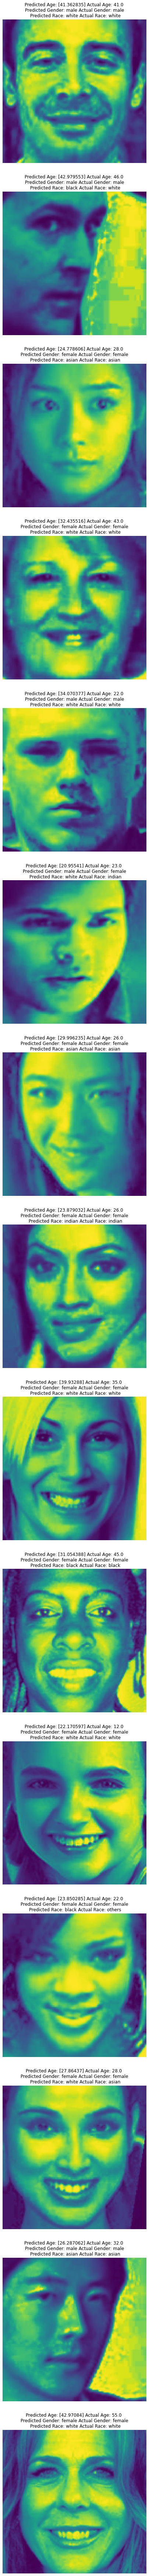

In [19]:
fig = plt.figure(figsize=(128, 128 ))
rows = 15
columns = 1

i = 1
for image , age_p, race_p, gender_p, age, race, gender in zip(images, age_pred, race_pred, gender_pred, age_true, race_true, gender_true):
    if i > 15:
        break
    image = np.array(image)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    plt.axis('off')
    # plt.title( 'Predicted gender : {} , actual gender : {}'.format( label_ , classes[ np.argmax( label ) ] ) )
    plt.title(f'Predicted Age: {age_p} Actual Age: {age} \n Predicted Gender: {dataset_dict["gender_id"][gender_p]} Actual Gender: {dataset_dict["gender_id"][gender]} \n Predicted Race: {dataset_dict["race_id"][race_p]} Actual Race: {dataset_dict["race_id"][race]}')
    i += 1

 
## 7) Convert to TensorFlow Lite format

Our model is to be deployed in an Android app, where we'll use [TF Lite Android](https://bintray.com/google/tensorflow/tensorflow-lite) package to parse the model and make predictions.

We use the `TFLiteConverter` API to convert our Keras Model ( `.h5` ) to a TF Lite buffer ( `.tflite` ). See the [official docs](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter/). We'll produce two TF Lite buffers, one with float16 quantization and other non-quantized model.


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model( model )
converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
converter.target_spec.supported_types = [ tf.float16 ]
buffer = converter.convert()

model_name = 'CZ4042-model-lite'

open( '{}_q.tflite'.format( model_name ) , 'wb' ).write( buffer )
# files.download( '{}_q.tflite'.format( model_name ) )

INFO:tensorflow:Assets written to: C:\Users\Bambi\AppData\Local\Temp\tmpp_swe07g\assets


INFO:tensorflow:Assets written to: C:\Users\Bambi\AppData\Local\Temp\tmpp_swe07g\assets


837888


For conversion to a non-quantized TF Lite buffer.


In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model( model )
buffer = converter.convert()

open( '{}_nonq.tflite'.format( model_name ) , 'wb' ).write( buffer )
files.download( '{}_nonq.tflite'.format( model_name ) )
